# Code to run and plot PCA

In [266]:
import numpy as np
import os  # For Saving to Folder
import pandas as pd
import matplotlib.pyplot as plt

import socket
import os as os
import sys as sys
import multiprocessing as mp
import itertools as it
from time import time

# For Arial Font
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'   # Set the defaul
rcParams['font.sans-serif'] = ['Arial']

socket_name = socket.gethostname()
print(socket_name)

if socket_name.startswith("compute-"):
    print("HSM Computational partition detected.")
    path = "/n/groups/reich/hringbauer/git/punic_aDNA/"  # The Path on Midway Cluster
else:
    raise RuntimeWarning("Not compatible machine. Check!!")

os.chdir(path)  # Set the right Path (in line with Atom default)
# Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns
print(os.getcwd())
print(f"CPU Count: {mp.cpu_count()}")
print(sys.version)

compute-e-16-230.o2.rc.hms.harvard.edu
HSM Computational partition detected.
/n/groups/reich/hringbauer/git/punic_aDNA
CPU Count: 28
3.7.4 (default, Sep 11 2019, 11:24:51) 
[GCC 6.2.0]


In [272]:
def remove_individuals(df, remove_list=["_d"], iid_col="iid"):
    """Remove indivdiuals from PCA dataframe"""
    idx = df[iid_col].str.contains("|".join(remove_list))
    df = df[~idx].copy()
    print(f"Filtering to {len(df)}/{len(idx)}")
    return df

def get_sub_iid(df, pops=[""], iid_col="iid"):
    """Remove indivdiuals from PCA dataframe"""
    idx = df[iid_col].str.contains("|".join(pops))
    df = df[idx].copy()
    print(f"Found: {len(df)}/{len(idx)}")
    return df

def get_sub_pops(df, pop_list=[], pop_col="pop"):
    """Get Sub Populations"""
    idx = df[pop_col].str.contains("|".join(pop_list))
    df = df[idx].copy()
    print(f"Found: {len(df)}/{len(idx)}")
    return df

def get_sub_pops_exact(df, pop_list=[], pop_col="pop"):
    """Get Sub Populations"""
    idx = df[pop_col].isin(pop_list)
    df = df[idx].copy()
    print(f"Found: {len(df)}/{len(idx)}")
    return df

####################################################
### Plotting PCA

def plot_pca(ax, df, c="gray", alpha=1.0, legend="", marker="o",
             s=30, ec=None):
    """Plot PCA onto Axis"""
    ax.scatter(-df["pc1"], df["pc2"], c=c, alpha=alpha, label=legend, 
               ec=ec, s=s, marker=marker)

In [269]:
min_snp = 30000
path_pca = "./output/pca/v44/20201116.punic1.v44_HO.construct_WE_NA_PCA.shrinkmode.evec.txt"

df = pd.read_csv(path_pca, 
                 sep=r"\s+", skiprows=1, header=None)
df.columns=["iid", "pc1", "pc2", "pc3", "pc4", "pop"]
df = remove_individuals(df, remove_list=["_d"])

df_meta = pd.read_csv("/n/groups/reich/hringbauer/Data/v44.0.anno.csv", sep=",")
df2 = df_meta[["iid", "Master ID", "n_cov_snp", "mean_cov", "sex"]]
df = pd.merge(df, df2, on="iid", how="left")
idx = (df["n_cov_snp"]<min_snp)
df = df[~idx]
print(f"Filtered to {len(df)} Individuals based on Min SNP: {min_snp}")

df = df.sort_values(by="n_cov_snp", ascending=False)
dup = (df["Master ID"].duplicated() & ~df["Master ID"].isnull())
df = df[~dup]
print(f"Filtered to {len(df)} based on duplicates")

Filtering to 2020/2131
Filtered to 1967 Individuals based on Min SNP: 30000
Filtered to 1899 based on duplicates


In [284]:
df_ho = get_sub_pops_exact(df, pop_list=["construct_WE_NA_PCA"])
df_is = get_sub_pops_exact(df, pop_list=["Israel_MLBA_Canaanite"])
df_le = get_sub_pops_exact(df, pop_list=["Lebanon_MBA_Canaanite.SG"])
df_isp = get_sub_pops_exact(df, pop_list=["Israel_Phoenician"])

df_sard = get_sub_pops_exact(df, pop_list=["Italy_Sardinia_Punic"])
df_sard_ba = get_sub_pops_exact(df, pop_list=["Italy_Sardinia_EBA","Italy_Sardinia_BA_Nuragic"])

df_tun = get_sub_pops_exact(df, pop_list=["Tunisia_N"])
df_vil = get_sub_iid(df, ["VIL"])
df_msr = get_sub_iid(df, ["MSR"])

df_greek = get_sub_pops_exact(df, pop_list=["Greece_BA_Mycenaean"])
df_alg = get_sub_pops_exact(df, pop_list=["Algeria_IA"])
df_spain = get_sub_pops_exact(df, pop_list=["Spain_IA"])

df_vill = get_sub_pops(df, pop_list=["Spain_Punic"])
df_ib = get_sub_pops_exact(df, ["Ibiza_Punic.SG"])
df_sic = get_sub_pops_exact(df, ["Italy_Phoenician_Sicily"])
df_sic2 = get_sub_pops_exact(df, ["Italy_Sicily_Punic"])
df_sic_ia = get_sub_pops_exact(df, ["Italy_Sicily_IA_Polizzello"])

Found: 1196/1899
Found: 23/1899
Found: 5/1899
Found: 16/1899
Found: 18/1899
Found: 23/1899
Found: 8/1899
Found: 6/1899
Found: 2/1899
Found: 14/1899
Found: 1/1899
Found: 19/1899
Found: 13/1899
Found: 1/1899
Found: 12/1899
Found: 23/1899
Found: 19/1899


Saved to: ./figures/west_med_punic_pca.pdf


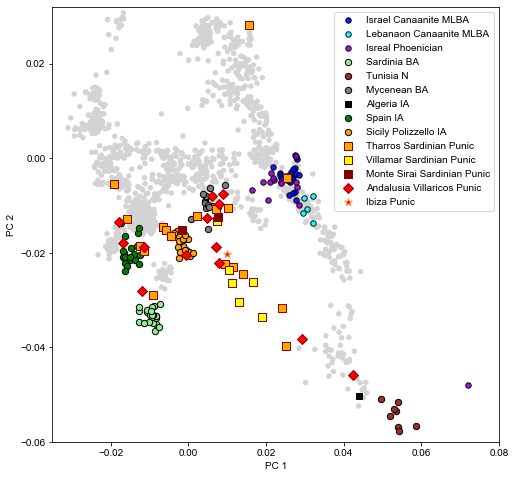

In [286]:
savepath="./figures/west_med_punic_pca.pdf"

plt.figure(figsize=(8,8))
ax = plt.gca()

plot_pca(ax, df_ho, c="lightgray")

plot_pca(ax, df_is, c="blue", legend="Israel Canaanite MLBA", ec="k", alpha=0.9)
plot_pca(ax, df_le, c="aqua", legend="Lebanaon Canaanite MLBA", ec="k", alpha=0.9)
plot_pca(ax, df_isp, c="darkviolet", legend="Isreal Phoenician", ec="k", alpha=0.9)
### Plot the Sardinian Samples
plot_pca(ax, df_sard_ba, c="lightgreen", legend="Sardinia BA", ec="k", s=40)
plot_pca(ax, df_tun, c="brown", legend="Tunisia N", ec="k", s=40)
plot_pca(ax, df_greek, c="gray", legend="Mycenean BA", ec="k", s=40)

plot_pca(ax, df_alg, c="k", legend="Algeria IA", s=40, marker="s", ec="k")
plot_pca(ax, df_spain, c="green", legend="Spain IA", s=40, ec="k")

plot_pca(ax, df_sic_ia, c="orange", legend="Sicily Polizzello IA", s=40, ec="k")

plot_pca(ax, df_sard, c="orange", legend="Tharros Sardinian Punic", ec="darkred", s=50, marker="s")
plot_pca(ax, df_vil, c="yellow", legend="Villamar Sardinian Punic", ec="darkred", s=50, marker="s")
plot_pca(ax, df_msr, c="maroon", legend="Monte Sirai Sardinian Punic", ec="darkred", s=50, marker="s")

plot_pca(ax, df_vill, c="red", legend="Andalusia Villaricos Punic", ec="darkred", s=50, marker="D")
plot_pca(ax, df_ib, c="red", legend="Ibiza Punic", ec="sandybrown", s=70, marker="*")

#plot_pca(ax, df_sic, c="k", legend="Sicilly Punic", ec="blue", s=70, marker=">")
#plot_pca(ax, df_sic2, c="coral", legend="Sicilly Punic2", ec="blue", s=70, marker=">")

ax.legend(loc="upper right", fontsize=10)
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_xlim([-0.035,0.08])
ax.set_ylim([-0.06,0.032])

if len(savepath) > 0:
    plt.savefig(savepath, bbox_inches = 'tight', 
                pad_inches = 0, dpi=600)
    print(f"Saved to: {savepath}")
    
plt.show()

### Sicilly

Saved to: ./figures/pca_sicilly_punic.pdf


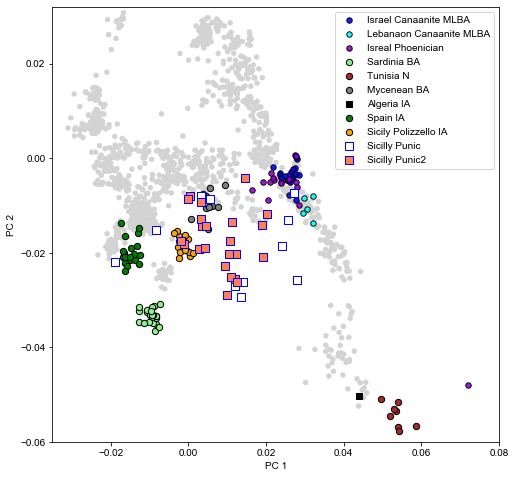

In [285]:
savepath="./figures/pca_sicilly_punic.pdf"

plt.figure(figsize=(8,8))
ax = plt.gca()

plot_pca(ax, df_ho, c="lightgray")

plot_pca(ax, df_is, c="blue", legend="Israel Canaanite MLBA", ec="k", alpha=0.9)
plot_pca(ax, df_le, c="aqua", legend="Lebanaon Canaanite MLBA", ec="k", alpha=0.9)
plot_pca(ax, df_isp, c="darkviolet", legend="Isreal Phoenician", ec="k", alpha=0.9)
### Plot the Sardinian Samples
plot_pca(ax, df_sard_ba, c="lightgreen", legend="Sardinia BA", ec="k", s=40)
plot_pca(ax, df_tun, c="brown", legend="Tunisia N", ec="k", s=40)
plot_pca(ax, df_greek, c="gray", legend="Mycenean BA", ec="k", s=40)

plot_pca(ax, df_alg, c="k", legend="Algeria IA", s=40, marker="s", ec="k")
plot_pca(ax, df_spain, c="green", legend="Spain IA", s=40, ec="k")
plot_pca(ax, df_sic_ia, c="orange", legend="Sicily Polizzello IA", s=40, ec="k")

#plot_pca(ax, df_sard, c="orange", legend="Tharros Sardinian Punic", ec="darkred", s=50, marker="s")
#plot_pca(ax, df_vil, c="yellow", legend="Villamar Sardinian Punic", ec="darkred", s=50, marker="s")
#plot_pca(ax, df_msr, c="maroon", legend="Monte Sirai Sardinian Punic", ec="darkred", s=50, marker="s")

#plot_pca(ax, df_vill, c="red", legend="Andalusia Villaricos Punic", ec="darkred", s=50, marker="D")
#plot_pca(ax, df_ib, c="red", legend="Ibiza Punic", ec="sandybrown", s=70, marker="*")

plot_pca(ax, df_sic, c="w", legend="Sicilly Punic", ec="blue", s=70, marker="s")
plot_pca(ax, df_sic2, c="coral", legend="Sicilly Punic2", ec="blue", s=70, marker="s")

ax.legend(loc="upper right", fontsize=10)
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_xlim([-0.035,0.08])
ax.set_ylim([-0.06,0.032])

if len(savepath) > 0:
    plt.savefig(savepath, bbox_inches = 'tight', 
                pad_inches = 0, dpi=600)
    print(f"Saved to: {savepath}")
    
plt.show()

### Area 51

In [231]:
df["pop"][df["pop"].str.contains("Ibiza")]

1438    Ibiza_Punic.SG
Name: pop, dtype: object

In [283]:
df1 = df[df["pop"].str.contains("Sic")]
df1["pop"].value_counts()

Italy_Sicily_Punic                     23
Italy_Sicily_IA_Polizzello             19
Italy_Phoenician_Sicily                12
Italy_Sicily_EBA                        7
Italy_Sicily_LA_Jewish_2                7
Sicily_Himera_480BCE_Greek              6
Italy_Sicily_LBA                        4
Italy_Sicily_LA_Jewish_1                3
Italy_Sicily_MN_all                     3
Sicily_Himera_409BCE                    3
Italy_Sicily_Islamic                    3
Sicily_Himera_409BCE.SG                 2
Sicily_Himera_480BCE_NEurope            2
Sicily_Himera_480BCE_shackled           2
Italy_Sicily_IA_Sicani                  2
Sicily_Himera_480BCE                    2
Sicily_Himera_480BCE_Balkan             2
Italy_Sicily_Roman                      2
Italy_unknown_Sicily                    2
Italy_Sicily_Punic_oEuropean            2
Sicily_Himera_480BCE_Sarmatian          2
Italy_Sicily_Modern                     2
Italy_Sicily_Punic_oNearEast            1
Italy_Sicily_EBA.SG               

In [170]:
df1[]

,iid,pc1,pc2,pc3,pc4,pop,Master ID,n_cov_snp,mean_cov,sex
1576,ORC002,0.0121,0.0495,-0.0385,-0.0038,Italy_Sardinia_IA_Punic_2,ORC002,914199.0,0.761833,M
1611,VIL006,-0.0223,0.0492,0.0064,-0.0159,Italy_Sardinia_IA_Punic_1,VIL006,468529.0,0.390441,F
1572,MSR003,0.0012,0.0255,-0.0191,0.0010,Italy_Sardinia_IA_Punic_2,MSR003,464497.0,0.387081,F
1612,VIL007,-0.0184,0.0389,0.0019,-0.0122,Italy_Sardinia_IA_Punic_1,VIL007,450084.0,0.375070,M
1615,VIL011,-0.0315,0.0552,0.0126,-0.0168,Italy_Sardinia_IA_Punic_1,VIL011,366554.0,0.305462,M
1571,MSR002,-0.0132,0.0198,-0.0120,-0.0038,Italy_Sardinia_IA_Punic_2,MSR002,365534.0,0.304612,M
1614,VIL010,-0.0275,0.0429,0.0068,-0.0155,Italy_Sardinia_IA_Punic_1,VIL010,173540.0,0.144617,F
1613,VIL009,-0.0195,0.0442,0.0047,-0.0102,Italy_Sardinia_IA_Punic_1,VIL009,77589.0,0.064658,F
1610,VIL004,-0.0120,0.0212,-0.0100,-0.0027,Italy_Sardinia_IA_Punic_2,VIL004,55509.0,0.046258,F


In [163]:
df_sard

,iid,pc1,pc2,pc3,pc4,pop,Master ID,n_cov_snp,mean_cov,sex
1711,I22118,0.0087,0.0227,-0.0165,-0.0088,Italy_Sardinia_Punic,I22118,820684.0,0.683903,M
1710,I22117,-0.0168,0.0172,-0.0122,-0.0012,Italy_Sardinia_Punic,I22117,809315.0,0.674429,M
1708,I22119,-0.0397,0.0063,-0.0102,0.0060,Italy_Sardinia_Punic,I22119,790656.0,0.658880,M
1709,I22112,0.0227,0.0217,-0.0067,-0.0010,Italy_Sardinia_Punic,I22112,789733.0,0.658111,F
1712,I22125,0.0123,0.0469,-0.0372,-0.0092,Italy_Sardinia_Punic,I22125,783042.0,0.652535,F
1702,I22115,0.0075,0.0251,-0.0111,-0.0031,Italy_Sardinia_Punic,I22115,782758.0,0.652298,M
1707,I22114,0.0277,0.0102,0.0022,0.0040,Italy_Sardinia_Punic,I22114,764145.0,0.636787,M
1704,I22120,0.0173,0.0311,-0.0106,-0.0060,Italy_Sardinia_Punic,I22120,755099.0,0.629249,M
1705,I22113,-0.0394,0.0521,0.0251,-0.0195,Italy_Sardinia_Punic,I22113,742454.0,0.618712,F
1706,I22122,-0.0047,0.0191,-0.0165,-0.0006,Italy_Sardinia_Punic,I22122,726610.0,0.605508,M
